In [1]:
import os
import platform
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [29]:
tf.get_logger().setLevel(logging.ERROR)

def _df(data, cols):
    df = pd.DataFrame(data)
#     df = df.rename?
    for c in range(df.shape[1]):
        mapping = {df.columns[c]: cols[c]}
        df = df.rename(columns=mapping)
    return df

In [3]:
def load_and_preprocess():
    #Reading the pre_processed data
    os_type = platform.system()
    if os_type.startswith("Darwin"):
        data = pd.read_excel(r"dataset/processed_data/main/final_cleaned_dataset.xlsx")
    else: 
        data = pd.read_excel(r"dataset\processed_data\main\final_cleaned_dataset.xlsx")
    #Droping the target col
    feature_value_temp = data.drop("Laboratory confirmed, since the beginning of the pandemic Hospitalized", axis=1)
    #Droping the Distric col as it is string and will be assigned value by clustering
    features = feature_value_temp.drop("District",axis=1)
    features = features.drop("Unnamed: 0",axis=1)
    features = features.drop("Laboratory confirmed, since the beginning of the pandemic TOTAL",axis=1)
    features = features.drop("Laboratory confirmed, since the beginning of the pandemic RecoveredA",axis=1)
    features = features.drop("Laboratory confirmed, since the beginning of the pandemic Deceased",axis=1)


    data['flag'] = 3  # Initialize the 'flag' column with 3
    data.loc[data['Laboratory confirmed, since the beginning of the pandemic Hospitalized'] <= 449, 'flag'] = 2
    data.loc[data['Laboratory confirmed, since the beginning of the pandemic Hospitalized'] <= 290, 'flag'] = 1

    target_col = data["flag"]
    
    return features, np.array(target_col)

In [4]:
class Gan():

    def __init__(self, data):


        self.data = data
        self.n_epochs = 200

    # Genereta random noise in a latent space
    def _noise(self):
        noise = np.random.normal(0, 1, self.data.shape)
        return noise

    def _generator(self):
        model = tf.keras.Sequential(name="Generator_model")
        model.add(tf.keras.layers.Dense(15, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(30, activation='relu'))
        model.add(tf.keras.layers.Dense(
            self.data.shape[1], activation='linear'))
        return model

    def _discriminator(self):
        model = tf.keras.Sequential(name="Discriminator_model")
        model.add(tf.keras.layers.Dense(25, activation='relu',
                                        kernel_initializer='he_uniform',
                                        input_dim=self.data.shape[1]))
        model.add(tf.keras.layers.Dense(50, activation='relu'))
        # sigmoid => real or fake
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    # define the combined generator and discriminator model,
    # for updating the generator
    def _GAN(self, generator, discriminator):
        discriminator.trainable = False
        generator.trainable = True
        model = tf.keras.Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    # train the generator and discriminator
    def train(self, generator, discriminator, gan):

        # determine half the size of one batch, for updating the  discriminator
        # manually enumerate epochs
        for epoch in range(self.n_epochs):
            
            # Train the discriminator
            generated_data = generator.predict(self._noise())
            labels = np.concatenate([np.ones(self.data.shape[0]), np.zeros(self.data.shape[0])])
            X = np.concatenate([self.data, generated_data])
            discriminator.trainable = True
            d_loss , _ = discriminator.train_on_batch(X, labels)

            # Train the generator
            noise = self._noise()
            g_loss = gan.train_on_batch(noise, np.ones(self.data.shape[0]))


            print('>%d, d1=%.3f, d2=%.3f' %(epoch+1, d_loss, g_loss))

        return generator

In [5]:
features, target_col = load_and_preprocess()
X_train, X_test, y_train, y_test = train_test_split(features, target_col, test_size=0.3, random_state=29)

model = Gan(data=X_train)
generator = model._generator()
descriminator = model._discriminator()
gan_model = model._GAN(generator=generator, discriminator=descriminator)
trained_model = model.train(generator=generator, discriminator=descriminator, gan=gan_model)

366/366 [==============================] - 0s 303us/step
>1, d1=0.459, d2=0.556
366/366 [==============================] - 0s 337us/step
>2, d1=0.451, d2=0.565
366/366 [==============================] - 0s 335us/step
>3, d1=0.447, d2=0.571
366/366 [==============================] - 0s 329us/step
>4, d1=0.441, d2=0.584
366/366 [==============================] - 0s 324us/step
>5, d1=0.435, d2=0.591
366/366 [==============================] - 0s 331us/step
>6, d1=0.430, d2=0.601
366/366 [==============================] - 0s 291us/step
>7, d1=0.426, d2=0.612
366/366 [==============================] - 0s 318us/step
>8, d1=0.417, d2=0.623
366/366 [==============================] - 0s 332us/step
>9, d1=0.412, d2=0.634
366/366 [==============================] - 0s 325us/step
>10, d1=0.410, d2=0.643
366/366 [==============================] - 0s 318us/step
>11, d1=0.409, d2=0.652
366/366 [==============================] - 0s 340us/step
>12, d1=0.406, d2=0.661
366/366 [============================

366/366 [==============================] - 0s 364us/step
>102, d1=0.286, d2=0.961
366/366 [==============================] - 0s 338us/step
>103, d1=0.285, d2=0.959
366/366 [==============================] - 0s 348us/step
>104, d1=0.284, d2=0.965
366/366 [==============================] - 0s 326us/step
>105, d1=0.283, d2=0.966
366/366 [==============================] - 0s 311us/step
>106, d1=0.281, d2=0.967
366/366 [==============================] - 0s 300us/step
>107, d1=0.279, d2=0.971
366/366 [==============================] - 0s 291us/step
>108, d1=0.275, d2=0.972
366/366 [==============================] - 0s 296us/step
>109, d1=0.271, d2=0.979
366/366 [==============================] - 0s 289us/step
>110, d1=0.265, d2=0.991
366/366 [==============================] - 0s 324us/step
>111, d1=0.259, d2=1.005
366/366 [==============================] - 0s 324us/step
>112, d1=0.253, d2=1.026
366/366 [==============================] - 0s 292us/step
>113, d1=0.248, d2=1.041
366/366 [=======

In [48]:
noise = np.random.normal(0, 1, X_train.shape)
poisoned_data = _df(data=trained_model.predict(noise), cols=features.columns.array)

366/366 [==============================] - 0s 311us/step


Text(0.5, 1.0, 'synthetic Data')

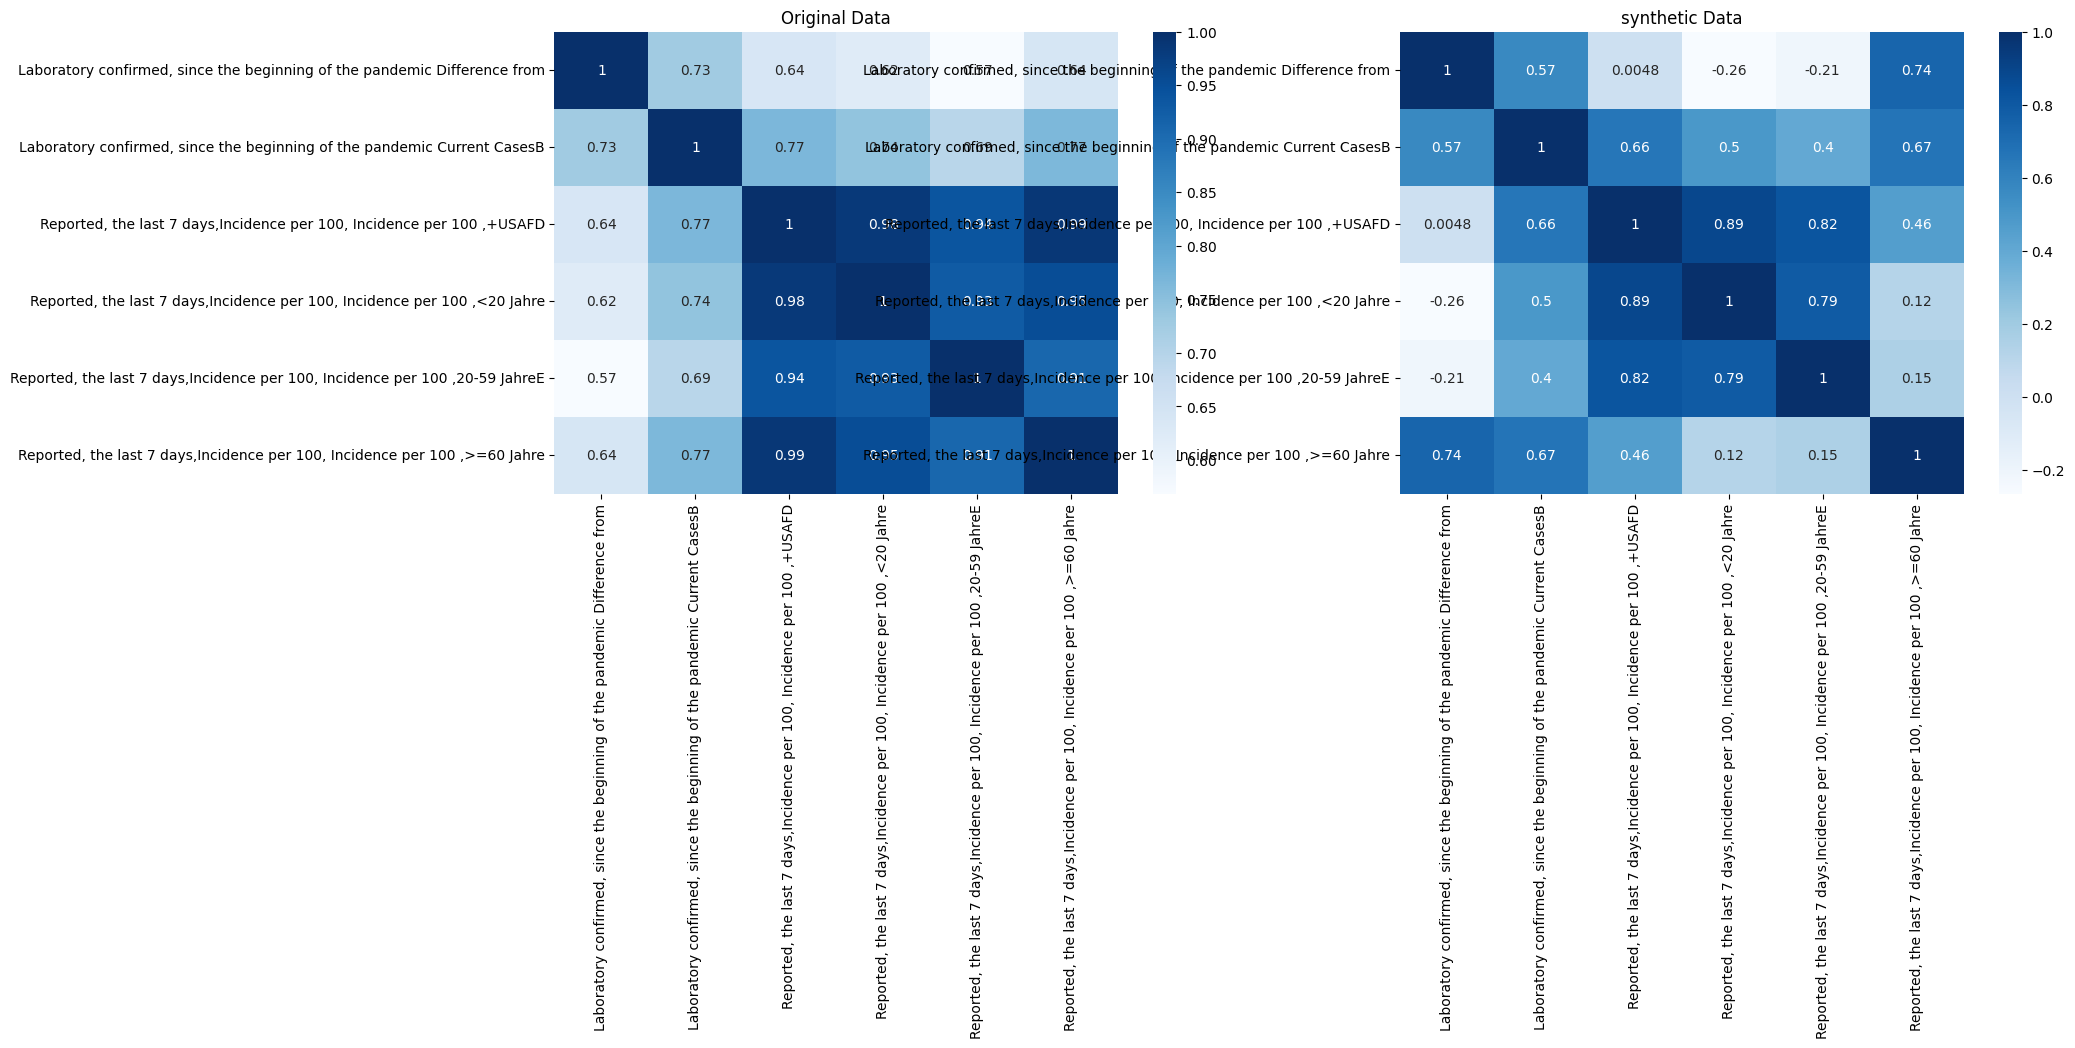

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(features.corr(), annot=True, ax=ax[0], cmap="Blues")
sns.heatmap(poisoned_data.corr(), annot=True, ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

Text(0.5, 1.0, 'synthetic Data')

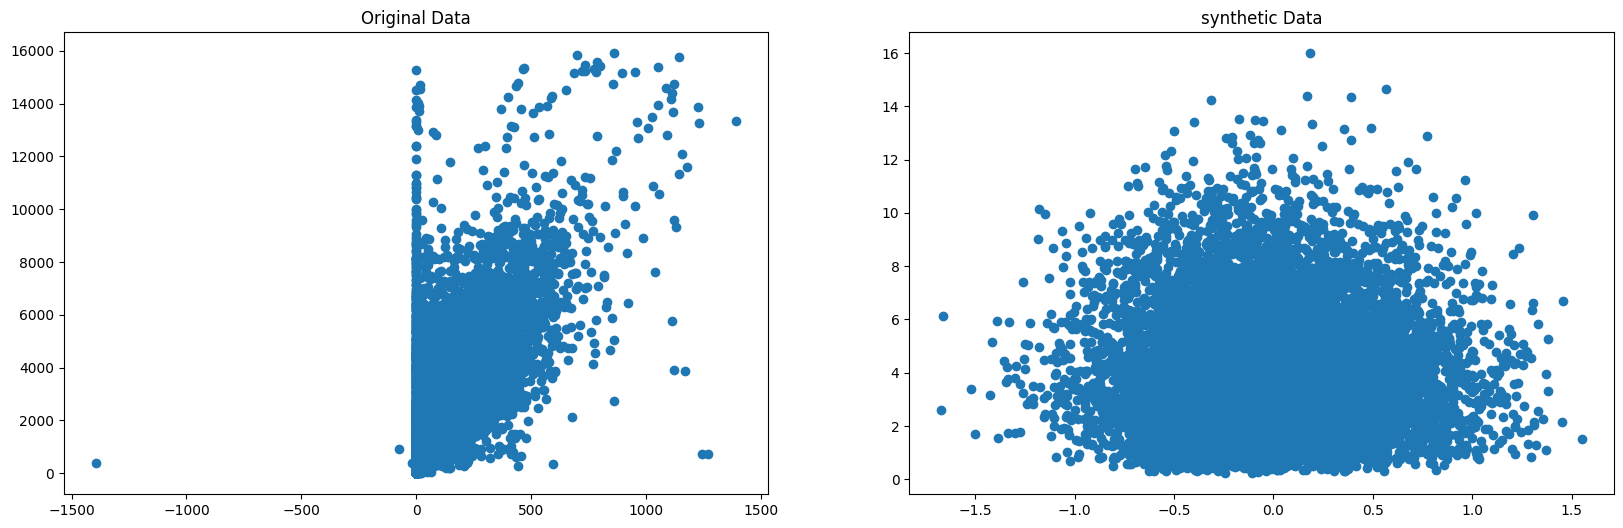

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(features.iloc[:, 0], features.iloc[:, 1])
ax[1].scatter(poisoned_data.iloc[:, 0], new_data.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

In [9]:
# np.save('GAN_generated_data.npy', new_data)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [51]:
model = RandomForestClassifier(n_estimators=50, random_state= 22)
model.fit(X=poisoned_data, y=y_train)

y_pred = model.predict(X_test)

# Calculate accuracy, recall, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,average='weighted')
precision = precision_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.50
Recall: 0.50
Precision: 0.29
F1 Score: 0.34
